In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
from torchvision.transforms import InterpolationMode
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

In [3]:
writer = SummaryWriter()

In [4]:
torch.cuda.current_device()
torch.cuda.set_device(2)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(93864621472352, 93864536955044)


In [5]:
# Hyper-parameters 
num_epochs = 100
batch_size = 256
learning_rate = 0.01

In [ ]:
#READ THE LABELS.CSV FILE GENERATED IN PREPROCESSING.IPYNB, HEADER ALREADY GONE HERE!!!
image_id_and_labels = pd.read_csv('ids_and_labels.csv',delimiter=',',header=1)
#print(image_id_and_labels.values)
image_id_and_labels_arr = np.array(image_id_and_labels.values)
#print(image_id_and_labels_arr)

In [ ]:
#ENCODE THE COUNTRY LABELS SO THAT DATASET CAN READ THEM As TENSORS
#label_encoder = LabelEncoder()
#image_id_and_labels_encoded = image_id_and_labels_arr.copy()
#label_encoder.fit(image_id_and_labels_encoded[:,3])
#encoded_countries = label_encoder.transform(image_id_and_labels_encoded[:,3])
#print(encoded_countries)
#image_id_and_labels_encoded[:,3] = encoded_countries
#print(image_id_and_labels_encoded)

In [ ]:
#TRAIN-VAL SPLIT AND SAVE AS SEPERATE CSV FILES

#ids_labels_train, ids_labels_val = train_test_split(image_id_and_labels_encoded, test_size=0.2, random_state=42)

#stratSplit = StratifiedShuffleSplit(n_splits=1, test_size = 0.25, random_state=42)
#for train_idx, test_idx in stratSplit.split(image_id_and_labels_encoded, np.zeros(len(image_id_and_labels_encoded))):
    #ids_labels_train, ids_labels_val = image_id_and_labels_encoded[train_idx], image_id_and_labels_encoded[test_idx]
    

#print(len(ids_labels_train))
#print(len(ids_labels_val))
#np.savetxt("ids_and_labels_train.csv", ids_labels_train, delimiter=",", fmt='%s')
#np.savetxt("ids_and_labels_val.csv", ids_labels_val, delimiter=",", fmt='%s')

In [ ]:
print(len(np.unique(ids_labels_train[:,3])))
print(len(np.unique(ids_labels_val[:,3])))
print(len(np.unique(image_id_and_labels_encoded[:,3])))  #NO OF COUNTRIES OVERALL

In [10]:
#CUSTOM DATASET CLASS
#class SN7Dataset(Dataset):
    
   # def __init__(self, transform=None, train=True):
        
        #if train == True:
            #self.img_ids_labels = pd.read_csv("ids_and_labels_train.csv", header = None) 
        #else:
            #self.img_ids_labels = pd.read_csv("ids_and_labels_val.csv", header = None)
            
        #self.img_dir = '/local/home/stuff/datasets/Challenge_7/train'
        #self.transform = transform
        
    #def __getitem__(self, idx):
        
        #image_id = self.img_ids_labels.iloc[idx, 0]
        #pattern = "mosaic_(.*?).tif"
        #location_id = re.search(pattern, image_id).group(1)
        ##print(image_id)
        #print(location_id)
        #img_path = os.path.join(self.img_dir, location_id, 'images', image_id )
        #image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        #label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 3]))
        #if self.transform:
            #image = self.transform(image)
        #if self.target_transform:
            #label = self.target_transform(label)
        #return image, label
        
    #def __len__(self):
        
        #return len(self.img_ids_labels)

class SN7Dataset(Dataset):
    
    def __init__(self, transform=None, train=True):
        
        if train == True:
            self.img_ids_labels = pd.read_csv("ids_and_labels_train_repeated.csv", header = None) 
        else:
            self.img_ids_labels = pd.read_csv("ids_and_labels_val_repeated.csv", header = None)
            
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/train'
        self.transform = transform
        
    def __getitem__(self, idx):
        #print(self.img_ids_labels.iloc[idx, 0])
        image_id, patch_id = self.img_ids_labels.iloc[idx, 0].split("!")[1],self.img_ids_labels.iloc[idx, 0].split("!")[0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        
        image_padded = torch.nn.functional.pad(image, pad=(0, 1024 - image.shape[2], 0, 1024 - image.shape[1]))
        patches = image_padded.unfold(1, 256, 256).unfold(2, 256, 256)
        patches = patches.reshape(3, -1, 256, 256)
        patches = patches.permute(1,0,2,3)
        
        image = patches[int(patch_id)]
        
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 3])).type(torch.LongTensor)
        
        #patches = patches.view(-1, 3, 256, 256)
        #print(patches.shape)
        #label = label.flatten()
        #label = label.type(torch.LongTensor)
        
        
        image = self.transform(image)
                
            
        #if self.target_transform:
            #label = self.target_transform(label)
            
        
        return image, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

In [11]:
#INSTANTIATE DATASETS
#transform = transforms.Compose([torchvision.transforms.Resize((1023,1023)), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   #OTHERWISE SOME IMAGES 1024, SOME 1023!!!
transform = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_dataset = SN7Dataset(train=True, transform = transform)
val_dataset = SN7Dataset(train=False, transform = transform)

train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = True)

#CHECK FOR TRAIN
#first_data = train_dataset[345]
#img, label = first_data
#plt.imshow(img.permute(1,2,0))     #OTHER WAY TO PLOT????????
#print(label_encoder.inverse_transform(label.detach().reshape(-1,1)))
#print(img.shape)
#print(type(img))
#print(type(label))


dataiter = iter(train_loader)
data = dataiter.next()
imgs, labels = data
print(imgs.shape)
print(labels.shape)

#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(np.transpose(imgs[i]))
#    print(label_encoder.inverse_transform(labels[i].detach().reshape(-1,1)))
#plt.show()

#print(len(train_dataset))

FileNotFoundError: [Errno 2] No such file or directory: 'ids_and_labels_train_repeated.csv'

In [7]:
#CHECK FOR VAL

#first_data = val_dataset[271]
#img, label = first_data
#plt.imshow(img.permute(1,2,0))     #OTHER WAY TO PLOT????????
#print(label_encoder.inverse_transform(label.detach().reshape(-1,1)))
#print(img.shape)
#print(type(img))
#print(type(label))


#dataiter = iter(val_loader)
#data = dataiter.next()
#imgs, labels = data
#print(imgs.shape)
#print(labels.shape)

#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(np.transpose(imgs[i]))
#    print(label_encoder.inverse_transform(labels[i].detach().reshape(-1,1)))
#plt.show()

#print(len(val_dataset))

torch.Size([256, 3, 256, 256])


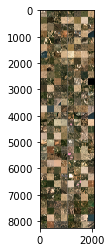

In [7]:
#CHECK FOR NORMALIZED IMAGES

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
#MODEL, LOSS AND OPTIMIZER
model = torchvision.models.resnet18().to(device)  #NOT PRETRAINED!
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
#DATA PARALLELISM FOR MULTİPLE GPUs
device = f'cuda:{model.device_ids[0]}'
model = nn.DataParallel(torchvision.models.resnet18(), device_ids = [2, 3]).to(device)
#NOTE: LOSS DIDNT DECREASE IN THIS CASE, %0 ACCURACY FOR ALL CLASSES!!!!

In [9]:
#TRAINING LOOP
n_total_steps = len(train_loader)
running_loss = 0.0
running_correct = 0
checkpoints = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % checkpoints == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            writer.add_scalar('training_loss', running_loss/checkpoints, epoch * n_total_steps + i)
            running_accuracy = running_correct/checkpoints/predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0

writer.flush()
writer.close()

print('Finished Training')

Epoch [1/100], Step [30/67], Loss: 3.4122
Epoch [1/100], Step [60/67], Loss: 2.6079
Epoch [2/100], Step [30/67], Loss: 2.1702
Epoch [2/100], Step [60/67], Loss: 1.9722
Epoch [3/100], Step [30/67], Loss: 1.6409
Epoch [3/100], Step [60/67], Loss: 1.6789
Epoch [4/100], Step [30/67], Loss: 1.5121
Epoch [4/100], Step [60/67], Loss: 1.3644
Epoch [5/100], Step [30/67], Loss: 1.5141
Epoch [5/100], Step [60/67], Loss: 1.3048
Epoch [6/100], Step [30/67], Loss: 1.2457
Epoch [6/100], Step [60/67], Loss: 1.2695
Epoch [7/100], Step [30/67], Loss: 1.2844
Epoch [7/100], Step [60/67], Loss: 1.1362
Epoch [8/100], Step [30/67], Loss: 1.0879
Epoch [8/100], Step [60/67], Loss: 1.1350
Epoch [9/100], Step [30/67], Loss: 0.9608
Epoch [9/100], Step [60/67], Loss: 0.9097
Epoch [10/100], Step [30/67], Loss: 0.9644
Epoch [10/100], Step [60/67], Loss: 0.9525
Epoch [11/100], Step [30/67], Loss: 0.9302
Epoch [11/100], Step [60/67], Loss: 0.9444
Epoch [12/100], Step [30/67], Loss: 1.0031
Epoch [12/100], Step [60/67],

Epoch [96/100], Step [60/67], Loss: 0.0189
Epoch [97/100], Step [30/67], Loss: 0.0313
Epoch [97/100], Step [60/67], Loss: 0.0144
Epoch [98/100], Step [30/67], Loss: 0.0216
Epoch [98/100], Step [60/67], Loss: 0.0284
Epoch [99/100], Step [30/67], Loss: 0.0399
Epoch [99/100], Step [60/67], Loss: 0.0318
Epoch [100/100], Step [30/67], Loss: 0.0340
Epoch [100/100], Step [60/67], Loss: 0.0263
Finished Training


In [13]:
#print(type(ids_labels_val[:,3]))
#val_classes = label_encoder.inverse_transform(ids_labels_val[:,3].astype('int'))
#classes = np.unique(val_classes)

classes = ['Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر', 'Australia', 'Brasil', 'Chile', 'Ghana',
 'India', 'Jamaica', 'México', 'Nederland', 'Oʻzbekiston', 'Panamá', 'Perú',
 'Philippines', 'România', 'South Africa', 'Sénégal', 'Uganda',
 'United Kingdom', 'United States', 'Zambia', 'Россия',
 'الإمارات العربية المتحدة' ,'السعودية' ,'السودان' ,'الكويت' ,'اليمن' ,'ليبيا',
 'مصر', 'বাংলাদেশ', '中国', '대한민국']

print(len(classes))

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    for images, labels in val_loader:
        images = images.to(device)  
        #print(labels.shape)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

31
Accuracy of the network: 87.34110169491525 %
Accuracy of Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر: 91.96428571428571 %
Accuracy of Australia: 75.0 %
Accuracy of Brasil: 91.66666666666667 %
Accuracy of Chile: 95.3125 %
Accuracy of Ghana: 79.16666666666667 %
Accuracy of India: 69.75 %
Accuracy of Jamaica: 93.75 %
Accuracy of México: 95.0 %
Accuracy of Nederland: 92.5 %
Accuracy of Oʻzbekiston: 80.55555555555556 %
Accuracy of Panamá: 76.25 %
Accuracy of Perú: 77.34375 %
Accuracy of Philippines: 89.84375 %
Accuracy of România: 76.38888888888889 %
Accuracy of South Africa: 86.71875 %
Accuracy of Sénégal: 92.96875 %
Accuracy of Uganda: 68.75 %
Accuracy of United Kingdom: 86.93181818181819 %
Accuracy of United States: 92.07089552238806 %
Accuracy of Zambia: 96.875 %
Accuracy of Россия: 75.0 %
Accuracy of الإمارات العربية المتحدة: 93.75 %
Accuracy of السعودية: 98.61111111111111 %
Accuracy of السودان: 82.03125 %
Accuracy of الكويت: 71.25 %
Accuracy of اليمن: 66.96428571428571 %
Accuracy of ليبيا: 96.25 %

In [ ]:
#MAY NEED TO SPLIT DATA WITH BALANCED CLASSES!!!(EQUAL NUM OF SAMPLES FROM EACH CLASS)
torch.cuda.empty_cache()